In [61]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from time import time
from torch import nn, optim
from torchvision import datasets, transforms

In [62]:
transforms = transforms.ToTensor()

trainset = datasets.MNIST('./data', download=True, train=True, transform=transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

valset = datasets.MNIST('./data', download=True, train=False, transform=transforms)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

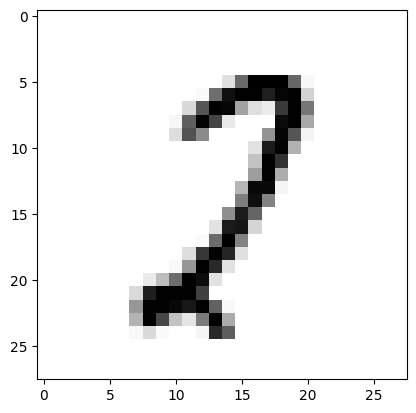

In [63]:
dataiter = iter(trainloader)
images, etiquetas = next(dataiter)
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

In [64]:
print(images[0].shape) #Verificando as dimensões do tensor de cada imagem
print(etiquetas[0].shape) #Verificando as dimensões do tensor de cada etiqueta

torch.Size([1, 28, 28])
torch.Size([])


In [65]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.linear1 = nn.Linear(28*28, 128) #Camada de entrada, 748 neurônios se ligam a 128
        self.linear2 = nn.Linear(128, 64) #Camada interna 1, 128 neurônios se ligam a 64
        self.linear3 = nn.Linear(64, 10) #Camada interna 2, 64 neurônios se ligam a 10
        # para a camada de saida não é necessário definir nada pois só precisamos pegar o output da camada interna 2
        
    def forward(self, X):
        X = F.relu(self.linear1(X)) # função de ativação da camada de entrada para a camada interna 1
        X = F.relu(self.linear2(X)) # função de ativação da camada interna 1 para a camada interna 2
        X = self.linear3(X) # função de ativação da camada interna 2 para a camada de saída, nesse caso f(x) = x
        return F.log_softmax(X, dim=1) # dados utilizados para calcular a perda

In [66]:
def treino(modelo, trainloader, device):
    otimizador = optim.SGD(modelo.parameters(), lr=0.01, momentum=0.9) # define a política de atualização dos pesos e da bias
    inicio = time() # inicia o cronômetro
    
    criterio = nn.NLLLoss() # define o criterio para calcular a perda
    EPOCHS = 10 # numero de epochs que o algoritmo rodará
    modelo.train() # coloca o modelo em modo de treinamento
    
    for epoch in range(EPOCHS):
        perda_acumulada = 0 # inicialização da perda acumulada da epoch em questão
        
        for imagens, etiquetas in trainloader:
            imagens = imagens.view(imagens.shape[0], -1) # convertendo as imagens para vetores de 28*28 casas para ficarem compativeis com a rede neural
            otimizador.zero_grad() # zerando os gradientes por conta do ciclo anterior
            
            output = modelo(imagens.to(device)) # colocando os dados no modelo
            perda_instantanea = criterio(output, etiquetas.to(device)) # calculando a perda da epoch em questão
            
            perda_instantanea.backward() # back propagation a partir da perda
            
            otimizador.step() # atualizando os pesos e a bias
            
            perda_acumulada += perda_instantanea.item() # atualização da perda acumulada
            
    else:
        print(f"Epoch {epoch+1}/{EPOCHS} - Perda: {perda_acumulada/len(trainloader)}")
    print("\nTempo de treino: ", time()-inicio)

In [67]:
def validacao(modelo, valloader, device):
    conta_corretas, conta_total, conta_incorretas = 0, 0, 0
    for imagens, etiquetas in valloader:
        for i in range(len(etiquetas)):
            img = imagens[i].view(1, 784) 
            # desativar o autograd para acelerar a validação. Grafos computacionais dinâmicos tem um custo alto de processamento
            with torch.no_grad():
                logps = modelo(img.to(device)) # output do modelo em escala logaritmica
                
            ps = torch.exp(logps) # convertendo o output do modelo para a escala normal (lembrando que é um tensor)
            probab = list(ps.cpu().numpy()[0])
            etiqueta_pred = probab.index(max(probab)) # converte o tensor em um número, no caso, o número que o modelo previu como correto
            etiqueta_certa = etiquetas.numpy()[i]
            
            if etiqueta_certa != etiqueta_pred:
                conta_incorretas += 1
            
            if (etiqueta_certa == etiqueta_pred):
                conta_corretas += 1
            conta_total += 1
            
    print("Total de imagens testadas = ", conta_total)
    print("\nPrecisão do modelo = {}%".format(100*conta_corretas/conta_total))
    print("Total de imagens incorretas = ", conta_incorretas)

In [69]:
modelo = Modelo()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # verifica se a GPU está disponível e define o dispositivo
modelo.to(device) # coloca o modelo no dispositivo definido acima

treino(modelo, trainloader, device) # treina o modelo
validacao(modelo, valloader, device) # valida o modelo

Epoch 10/10 - Perda: 0.037833731997061144

Tempo de treino:  63.84479784965515
Total de imagens testadas =  10000

Precisão do modelo = 97.8%
Total de imagens incorretas =  220
